# Visualization with REFINED

In this notebook we show how to convert tabular data into images, and show those images for visualization. As it is explained in the main markdown, REFINED has two steps: Initialization with manifold learning techniques (MDS), and optimization with a search technique (hill climbing). Therefore to perform visualization with REFINED, we need to do the two steps and once we get the coordinate in the square image for each feature of the tabular data we can generate images associate with each datapoint (sample).

### 1. In the below cell we perform initialization with MDS

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Toolbox import two_d_eq, Assign_features_to_pixels
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
import math
#%% Loading the data
Feat_DF = pd.read_csv("data/normalized_padel_feats_NCI60_672_small.csv")
X = Feat_DF.values
original_input = pd.DataFrame(data = X)                              # The MDS input should be in a dataframe format with rows as samples and columns as features

feature_names_list = Feat_DF.columns.tolist()                 # Extracting feature_names_list (gene_names or descriptor_names)
print(">>>> Data  is loaded")

#%% MDS
nn = math.ceil(np.sqrt(len(feature_names_list)))    			     # Image dimension
Nn = original_input.shape[1] 										 # Number of features
transposed_input = original_input.T 							     # The MDS input data must be transposed , because we want summarize each feature by two values (as compard to regular dimensionality reduction each sample will be described by two values)
Euc_Dist = euclidean_distances(transposed_input) 					 # Euclidean distance
Euc_Dist = np.maximum(Euc_Dist, Euc_Dist.transpose())   			 # Making the Euclidean distance matrix symmetric
embedding = MDS(n_components=2)										 # Reduce the dimensionality by MDS into 2 components
mds_xy = embedding.fit_transform(transposed_input)					 # Apply MDS

print(">>>> MDS dimensionality reduction is done")

eq_xy = two_d_eq(mds_xy,Nn) # -> [0,1]
Img = Assign_features_to_pixels(eq_xy,nn,verbose=0)					# Img is the none-overlapping coordinates generated by MDS

#%% To be saved for hill climbing
Desc = Feat_DF.columns.tolist();                					# Drug descriptors name
Dist = pd.DataFrame(data = Euc_Dist, columns = Desc, index = Desc)	# Generating a distance matrix which includes the Euclidean distance between each and every descriptor


>>>> Data  is loaded


c:\Users\vanek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


>>>> MDS dimensionality reduction is done


### 2. Hill Climbing
Once the initializaiton is performed, then we have to apply the search optimizaition (hill climbing). The below bash script will run the search optimization.

In [9]:
# without MPI
from itertools import product
import paraHill



# Convert from 'F34' to int 34
init_map = np.char.strip(Img.astype(str),'F').astype(int)
map_in_int = init_map

iters_count = 1

for iter_num in range(iters_count):
    init_coords = [x for x in product([0,1,2],repeat = 2)]
    for init_coord in init_coords:
        # generate the centroids
        xxx = [init_coord[0]+i*3 for i in range(int(nn/3)+1) if (init_coord[0]+i*3)<nn]
        yyy = [init_coord[1]+i*3 for i in range(int(nn/3)+1) if (init_coord[1]+i*3)<nn]
        centr_list = [x for x in product(xxx,yyy)]
        swap_dict = paraHill.evaluate_centroids_in_list(centr_list,Dist,map_in_int)
        print(swap_dict)
        map_in_int = paraHill.execute_dict_swap(swap_dict, map_in_int)

        print(">",init_coord,"Corr:",paraHill.universial_corr(Dist,map_in_int))


coords = np.array([[item[0] for item in np.where(map_in_int == ii)] for ii in range(Nn)])


c:\Users\vanek\Desktop\Диплом\REFINED\paraHill.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_array = np.array(results)


{(0, 0): 5, (0, 3): 6, (0, 6): 4, (0, 9): 9, (0, 12): 4, (3, 0): 8, (3, 3): 8, (3, 6): 7, (3, 9): 7, (3, 12): 1, (6, 0): 2, (6, 3): 2, (6, 6): 5, (6, 9): 2, (6, 12): 7, (9, 0): 5, (9, 3): 6, (9, 6): 6, (9, 9): 7, (9, 12): 2, (12, 0): 2, (12, 3): 1, (12, 6): 6, (12, 9): 1, (12, 12): 5}
> (0, 0) Corr: [3.67575049]
{(0, 1): 7, (0, 4): 6, (0, 7): 5, (0, 10): 4, (3, 1): 8, (3, 4): 3, (3, 7): 9, (3, 10): 7, (6, 1): 2, (6, 4): 7, (6, 7): 5, (6, 10): 3, (9, 1): 9, (9, 4): 9, (9, 7): 2, (9, 10): 7, (12, 1): 1, (12, 4): 1, (12, 7): 6, (12, 10): 3}
> (0, 1) Corr: [3.67433946]
{(0, 2): 5, (0, 5): 6, (0, 8): 5, (0, 11): 4, (3, 2): 5, (3, 5): 5, (3, 8): 7, (3, 11): 1, (6, 2): 8, (6, 5): 4, (6, 8): 5, (6, 11): 7, (9, 2): 5, (9, 5): 3, (9, 8): 2, (9, 11): 2, (12, 2): 1, (12, 5): 4, (12, 8): 6, (12, 11): 5}
> (0, 2) Corr: [3.67304463]
{(1, 0): 8, (1, 3): 7, (1, 6): 4, (1, 9): 4, (1, 12): 1, (4, 0): 8, (4, 3): 5, (4, 6): 5, (4, 9): 7, (4, 12): 1, (7, 0): 5, (7, 3): 3, (7, 6): 5, (7, 9): 5, (7, 12): 7, (

### 3. Visualization
Once the search optimization is performed and the coordinates for features are obtained, we can use the coordinates to generate images for visualization purpose or training CNNs. In the below code visualization is performed.

[[0.71655579 0.68160492 0.66389444 ... 0.02478961 0.02215929 0.00417476]
 [0.71822979 0.68049379 0.66240737 ... 0.01236443 0.00946707 0.00341744]
 [0.72642959 0.66381929 0.66936004 ... 0.02716862 0.0240677  0.00622205]
 ...
 [0.71933585 0.6806441  0.66209061 ... 0.01046305 0.00782921 0.0028176 ]
 [0.71867458 0.6829613  0.65934495 ... 0.01695405 0.01621156 0.00348394]
 [0.7158325  0.68388831 0.66271436 ... 0.02112916 0.01862069 0.00404091]]
<class 'numpy.ndarray'>


(-0.5, 12.5, 12.5, -0.5)

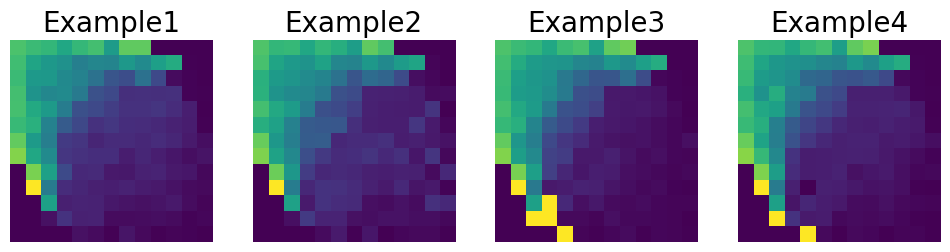

In [12]:
#%% Visualizing REFFINED images
from Toolbox import REFINED_Im_Gen

# We pick the first 100 data points because of computational costs, but you can pick the entire datasets.
X_REFINED_MDS = REFINED_Im_Gen(X[:,:],nn, map_in_int, Desc, coords)
Font = 20
print(X_REFINED_MDS)
print(type(X_REFINED_MDS))


fig=plt.figure(figsize=(12,8), dpi= 100)
plt.subplot(141)
plt.imshow(X_REFINED_MDS[1,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example1", fontsize = Font)
plt.axis('off')

plt.subplot(142)
plt.imshow(X_REFINED_MDS[2,:].reshape(nn, nn), cmap = 'viridis')
plt.title("Example2", fontsize = Font)
plt.axis('off')

plt.subplot(143)
plt.imshow(X_REFINED_MDS[3,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example3", fontsize = Font)
plt.axis('off')


plt.subplot(144)
plt.imshow(X_REFINED_MDS[4,:].reshape(nn,nn), cmap = 'viridis')
plt.title("Example4", fontsize = Font)
plt.axis('off')


In [19]:

X_reshaped = X_REFINED_MDS.reshape(X_REFINED_MDS.shape[0], nn, nn)
print(X_reshaped.shape)
plt.imsave("test1.png", X_reshaped[0])

(19, 13, 13)
